<a href="https://colab.research.google.com/github/ganeshkumar269/colabnotebooks/blob/main/miniproject_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
base_path = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/'
gt_path = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Part3_GroundTruth.csv'

In [ ]:
!pip install tensorboardX

In [ ]:
i=1
while i > 0:
  if i%10000 == 0 :
    print(i)
  if i > 100000000:
    i=1

In [ ]:
#@title train_mel.py {form-width : "50px"}

from tqdm import tqdm
from torch.utils import data
import torch.optim as optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter





RANDOM_SEED = 6666


def main():
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    def train(model, dataloader, criterion, optimizer):
        model.train()
        losses = []
        acc = 0.0
        for index, (images, labels, _) in enumerate(dataloader):
            labels = labels.to(device).unsqueeze(1).float()
            images = images.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            logps = F.logsigmoid(predictions)
            ps_ = torch.exp(logps)
            equals = torch.ge(ps_, 0.5).float() == labels
            acc += equals.sum().item()
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = sum(losses) / len(losses)
        train_acc = acc / len(dataloader.dataset)
        print(f'\ntrain_Accuracy: {train_acc:.5f}, train_Loss: {train_loss:.5f}')
        return train_acc, train_loss

    def validation(model, dataloader, criterion):
        model.eval()
        with torch.no_grad():
            running_acc = 0.0
            val_losses = []
            for index, (images, labels, _) in enumerate(dataloader, start=1):
                labels = labels.to(device).unsqueeze(1).float()
                images = images.to(device)
                # hogs = hogs.to(device)
                score = []
                for i in range(len(images[0])):
                    ps = model(images[:,i])
                    score.append(ps)
                score = sum(score) / len(score)
                logps = F.logsigmoid(score)
                ps_ = torch.exp(logps)
                loss = criterion(score, labels)
                val_losses.append(loss.item())
                equals = torch.ge(ps_, 0.5).float() == labels
                running_acc += equals.sum().item()
            val_loss = sum(val_losses) / len(val_losses)
            val_acc = running_acc / len(dataloader.dataset)
            print(f'\nval_Accuracy: {val_acc:.5f}, val_Loss: {val_loss:.5f}')
        return val_acc, val_loss

    def save_checkpoint():
        filename = os.path.join(checkpoint_dir, "mel_arlnet50_b32_best_acc.pkl")
        # torch.save(model.state_dict(), filename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, filename)

    def adjust_learning_rate():
        nonlocal lr
        lr = lr / lr_decay
        return optim.SGD(model.parameters(), lr, weight_decay=weight_decay, momentum=0.9)

    # set the parameters
    data_dir = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data'
    # Create the dataloaders
    batch_size = 32
    # the checkpoint dir
    checkpoint_dir = "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint"

    # the learning rate para
    lr = 1e-4
    lr_decay = 2
    weight_decay = 1e-4

    stage = 0
    start_epoch = 0
    stage_epochs = [30, 30, 30, 10]
    total_epochs = sum(stage_epochs)
    writer_dir = os.path.join(checkpoint_dir, "mel_arlnet50")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if not os.path.exists(writer_dir):
        os.makedirs(writer_dir)

    writer = SummaryWriter(writer_dir)

    train_transforms = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.7079057, 0.59156483, 0.54687315],
                             std=[0.09372108, 0.11136277, 0.12577087])
    ])

    val_transforms = argumentation_val()
    # training dataset
    train_dataset = ISICDataset(path=data_dir, mode="training", crop=None, transform=train_transforms, task="mel")
    val_dataset = ISICDataset(path=data_dir, mode="validation", crop=None, transform=val_transforms, task="mel")

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    # get the model
    model = arlnet50(pretrained=True)

    # the loss function
    criterion = nn.BCEWithLogitsLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = criterion.to(device)

    # the optimizer
    optimizer = optim.SGD(model.parameters(), lr, weight_decay=weight_decay, momentum=0.9)

    # initialize the accuracy
    acc = 0.0
    for epoch in tqdm(range(start_epoch, total_epochs)):

        train_acc, train_loss = train(model, train_loader, criterion, optimizer)
        val_acc, val_loss = validation(model, val_loader, criterion)
        writer.add_scalar("train acc", train_acc, epoch)
        writer.add_scalar("train loss", train_loss, epoch)
        writer.add_scalar("val accuracy", val_acc, epoch)
        writer.add_scalar("val loss", val_loss, epoch)

        if val_acc > acc or val_acc == acc:
            acc = val_acc
            print("save the checkpoint, the accuracy of validation is {}".format(acc))
            save_checkpoint()

        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50/mel_arlnet50_b32_epoches_{}.pkl".format(epoch + 1))

        if (epoch + 1) in np.cumsum(stage_epochs)[:-1]:
            stage += 1
            optimizer = adjust_learning_rate()
            print('Step into next stage')

        if (epoch + 1) == 50:
            torch.save(model.state_dict(), "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50/mel_arlnet50_b32_epoches_{}.pkl".format(epoch + 1))


if __name__ == '__main__':
    main()

In [7]:
#@title dataset2017.py { form-width: "50px" }
from torch.utils import data
import pandas as pd
import os
import torch
from PIL import Image
import numpy as np
class ISICDataset(data.Dataset):

    def __init__(self, path, mode="training", crop=None, transform=None, task=None):
        self.path = path
        self.mode = mode
        self.samples = self.make_dataset(path)
        self.crop = crop
        self.transform = transform
        self.task = task
        self.image_list = []

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, melanoma, seborrheic_keratosis = self.samples[idx]
        img_name = img_path.split("/")[-1]
        image = self.pil_loader(img_path)
        if self.crop:
            image = self.crop(image)
        if self.transform:
            image = self.transform(image)
        if self.task=="mel":
            return image, torch.from_numpy(np.array(int(melanoma))), img_name
        elif self.task=="sk":
            return image, torch.from_numpy(np.array(int(seborrheic_keratosis))), img_name
        else:
            return image, torch.FloatTensor([torch.from_numpy(np.array(int(melanoma))), torch.from_numpy(np.array(int(seborrheic_keratosis)))]), img_name
        

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def make_dataset(self, dir):
        images = []
        if self.mode == "training":
            img_dir = os.path.join(dir, "ISIC-2017_Training_Data_Patch_2")
            csv_filename = os.path.join(dir, "ISIC-2017_Training_Part3_GroundTruth_patch_2.csv")
        if self.mode == "validation":
            img_dir = os.path.join(dir, "After-Enhancement-Val-2")
            csv_filename = os.path.join(dir, "validation_gt.csv")
        if self.mode == "testing":
            img_dir = os.path.join(dir, "ISIC-2017_Test_v2_Data")
            csv_filename = os.path.join(dir, "ISIC-2017_Test_v2_Part3_GroundTruth.csv")
        label_list = pd.read_csv(csv_filename)

        for index, row in label_list.iterrows():
            if self.mode == "training":
                images.append((os.path.join(img_dir, row["image_id"] + ".png"), row["melanoma"], row["seborrheic_keratosis"]))
            else:
                images.append((os.path.join(img_dir, row["image_id"] + ".jpg"), row["melanoma"], row["seborrheic_keratosis"]))
        return images

In [8]:
#@title crop_transform.py { form-width: "50px" }
from PIL import Image
from torchvision import transforms
import pandas as pd
import os
import glob as gb
import torch
import numpy as np
import random
import warnings
from scipy import ndimage
import cv2
def rescale_crop(image, scale, num, mode):
    image_list = []
    h, w = image.size
    if mode=="train":
        trans = transforms.Compose([
        transforms.CenterCrop((int(h * scale) + 500 * scale, int(w * scale) + 500 * scale)),
        transforms.RandomCrop((int(h * scale), int(w * scale))),
        transforms.Resize((224,224)),
        transforms.RandomRotation((-10,10)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])
    elif mode=="val":
        trans = transforms.Compose([
            transforms.CenterCrop((int(h * scale) + 500 * scale, int(w * scale) + 500 * scale)),
            transforms.RandomCrop((int(h * scale), int(w * scale))),
            transforms.Resize((224, 224)),
        ])
    for i in range(num):
        img = trans(image)
        image_list.append(img)
    return image_list

def crop(image, mode):
    image_list = []
    if mode=="train":
        trans = transforms.Compose([

        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize((224, 224)),  #change the order
    ])
    elif mode=="val":
        trans = transforms.Compose([
            transforms.Resize((224, 224)),
        ])
    img = trans(image)
    image_list.append(img)
    return image_list

class argumentation(object):
    def __call__(self, image):
        image_list1 = rescale_crop(image, 0.2, 15, "train")
        image_list2 = rescale_crop(image, 0.4, 15, "train")
        image_list3 = rescale_crop(image, 0.6, 15, "train")
        image_list4 = rescale_crop(image, 0.8, 15, "train")
        image_list5 = crop(image, "train")
        image_list = image_list1 + image_list2 + image_list3 + image_list4 + image_list5
        nomalize = transforms.Lambda(lambda crops: torch.stack([transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.7079057, 0.59156483, 0.54687315],
                             std=[0.09372108, 0.11136277, 0.12577087])])(crop) for crop in crops]))
        random.shuffle(image_list)
        image_list = nomalize(image_list)
        return image_list

class argumentation_val(object):
    def __call__(self, image):
        image_list1 = rescale_crop(image, 0.2, 2, "val")
        image_list2 = rescale_crop(image, 0.4, 2, "val")
        image_list3 = rescale_crop(image, 0.6, 2, "val")
        image_list4 = rescale_crop(image, 0.8, 2, "val")
        image_list5 = crop(image, "val")
        image_list = image_list1 + image_list2 + image_list3 + image_list4 + image_list5
        nomalize = transforms.Lambda(lambda crops: torch.stack([transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.7079057, 0.59156483, 0.54687315],
                             std=[0.09372108, 0.11136277, 0.12577087])])(crop) for crop in crops]))
        image_list = nomalize(image_list)
        return image_list

In [ ]:
#@title generate_patch_images.py { form-width: "50px" }
import os
from tqdm import tqdm
import glob as gb
import pandas as pd
from PIL import Image
from torchvision import transforms

def get_images(root_path):
    files = []
    for ext in ['jpg']:
        files.extend(gb.glob(os.path.join(root_path, '*.{}'.format(ext))))
    return files

def rescale_crop(image, scale, num, ori=False):
    image_list = []
    h, w = image.size
    if ori:
        trans = transforms.Resize((224,224))
    else:
        trans = transforms.Compose([
        transforms.CenterCrop((int(h * scale) + 500 * scale, int(w * scale) + 500 * scale)),
        transforms.RandomCrop((int(h * scale), int(w * scale))),
        transforms.Resize((224,224))
    ])
    for i in range(num):
        img = trans(image)
        image_list.append(img)
    return image_list

data_dir = "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data/"
new_data_dir = base_path +'ISIC-2017_Training_Data_Patch_2/'
excel_dir = base_path + "ISIC-2017_Training_Part3_GroundTruth.csv"
new_excel_dir = base_path + "ISIC-2017_Training_Part3_GroundTruth_patch_2.csv"
images = get_images(data_dir)

if not os.path.exists(new_data_dir):
    os.makedirs(new_data_dir)


ids = []
mels = []
sks = []
for img in tqdm(images):
    image = Image.open(img)
    labels = pd.read_csv(excel_dir)
    mel = int(labels.loc[labels['image_id'] == img[img.rfind('/')+1:-4]]['melanoma'].values.squeeze())
    sk = int(labels.loc[labels['image_id'] == img[img.rfind('/')+1:-4]]['seborrheic_keratosis'].values.squeeze())
    image_list1 = rescale_crop(image, 0.2, 15)
    image_list2 = rescale_crop(image, 0.4, 15)
    image_list3 = rescale_crop(image, 0.6, 15)
    image_list4 = rescale_crop(image, 0.8, 15)
    image_list5 = rescale_crop(image, 1, 1, True)
    image_list_all = image_list1 + image_list2 + image_list3 + image_list4 + image_list5

    for i in range(len(image_list_all)):
        new_name = img[img.rfind('/')+1:-4] + '_' + str(i) + '.png'
        new_dir = os.path.join(new_data_dir, new_name)
        image_list_all[i].save(new_dir)
        labels = pd.read_csv(excel_dir)
        ids.append(new_name[:-4])
        mels.append(mel)
        sks.append(sk)
data_frame = pd.DataFrame({"image_id": ids, "melanoma": mels, "seborrheic_keratosis": sks})
data_frame.to_csv(new_excel_dir, index=False, sep=",")

100%|██████████| 2000/2000 [2:13:06<00:00,  3.99s/it]


600it [16:25,  1.64s/it]


0.8522588522588522
mel_Accuracy: 0.8516666666666667
mel_Sensitive: 0.4358974358974359
mel_Specificity: 0.9523809523809523
mel_AUC: 0.8522588522588522


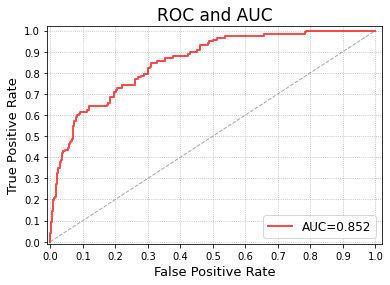

In [11]:
#@title predict_2017.py { form-width: "50px" }
import json
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils import data
# from dataset2017 import ISICDataset
from sklearn import metrics
import matplotlib.pyplot as plt
# from crop_transform import *
# from models.ARL import arlnet50
RANDOM_SEED = 6666


def main():
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    # set the parameters
    checkpoint_dir = base_path + "checkpoint/mel_arlnet50_b32_best_acc_third.pkl"
    result_dir = base_path + "result"
    data_dir = base_path
    # Create the dataloaders
    batch_size = 1

    y = []
    y_score = []

    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    def imshow(y_pre, y_score):
        fpr, tpr, thresholds = metrics.roc_curve(y_pre, y_score)
        auc = metrics.auc(fpr, tpr)
        print(auc)

        plt.plot(fpr, tpr, c='r', lw=2, alpha=0.7, label=u'AUC=%.3f' % auc)
        plt.plot((0, 1), (0, 1), c='#808080', lw=1, ls='--', alpha=0.7)
        plt.xlim((-0.01, 1.02))
        plt.ylim((-0.01, 1.02))
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xlabel('False Positive Rate', fontsize=13)
        plt.ylabel('True Positive Rate', fontsize=13)
        plt.grid(b=True, ls=':')
        plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
        plt.title(u'ROC and AUC', fontsize=17)
        plt.savefig("/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data/2017_mel_arlnet50_e100_b32_third.png")


    def load_checkpoint(checkpoint_path):

        # Here put the pretrained model that you used (in my case it's densenet161).

        # model = resnet50()
        # # model = danet()
        # # model = resnet50_cbam(pretrained=False)
        # # model = se_resnet50()
        # # model = proposed()
        # # model = models.resnext50_32x4d(pretrained=False)
        # try:
        #     n_ftrs = model.classifier.in_features
        #     model.classifier = classifier(n_ftrs)
        # except AttributeError:
        #     n_ftrs = model.fc.in_features
        #     model.fc = classifier(n_ftrs)
        # model = model.to(device)
        '''
        fn1 = FeatureNet_1()
        fn2 = FeatureNet_2()
        cfn = ClassifierNet(fn1, fn2) 
        model = cfn
        '''
        model = arlnet50(pretrained=True)
        # checkpoint = torch.load(checkpoint_path, map_location='cpu')
        checkpoint_t = torch.load(checkpoint_path, map_location='cuda')
        '''
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in checkpoint.items():
            name = k[7:]  # remove module.
            new_state_dict[name] = v
        '''
        model.load_state_dict(checkpoint_t['model_state_dict'])  # your checkpoint's key may differ (e.g.'state_dict')
        model.eval()
        return model

    def predict(model, dataloader):
        mel_tn = 0
        mel_fp = 0
        mel_tp = 0
        mel_fn = 0
        model.eval()
        with torch.no_grad():
            for ii, (images, labels, _) in tqdm(enumerate(dataloader, start=1)):
                images = images.to(device)
                scores = []

                for i in range(len(images[0])):
                    pred = model(images[:, i])
                    scores.append(pred)
                scores = sum(scores) / len(scores)
                logps = F.logsigmoid(scores)
                score = torch.exp(logps)
                pre = torch.ge(score, 0.5).float()
                if int(pre) == 0 and int(labels) == 0:
                    mel_tn += 1
                elif int(pre) == 1 and int(labels) == 0:
                    mel_fp += 1
                elif int(pre) == 1 and int(labels) == 1:
                    mel_tp += 1
                elif int(pre) == 0 and int(labels) == 1:
                    mel_fn += 1
                score = score.cpu().numpy().tolist()[0]
                label = labels.cpu().numpy().tolist()[0]
                y.append(label)
                y_score.append(score)
        return mel_tp, mel_tn, mel_fp, mel_fn

    val_transforms = argumentation_val()
    # Validation dataset
    val_dataset = ISICDataset(path=data_dir, mode="testing", crop=None, transform=val_transforms, task="mel")
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda")

    model = load_checkpoint(checkpoint_path=checkpoint_dir)

    model.cuda()
    mel_tp, mel_tn, mel_fp, mel_fn = predict(model, val_loader)

    mel_acc = (mel_tp + mel_tn) / (mel_tn + mel_fp + mel_tp + mel_fn)
    mel_sen = mel_tp / (mel_tp + mel_fn)
    mel_spe = mel_tn / (mel_tn + mel_fp)

    y_score = np.array(y_score)
    mel_auc = metrics.roc_auc_score(y, y_score)

    imshow(y, y_score)

    print('mel_Accuracy:', mel_acc)
    print('mel_Sensitive:', mel_sen)
    print('mel_Specificity:', mel_spe)
    print('mel_AUC:', mel_auc)
    with open('/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/result/result_third.txt', 'a') as f:
        f.write('\n2017_mel_arlnet50_e100_b32: ' + json.dumps(
            {'mel_Accuracy': mel_acc, 'mel_Sensitive': mel_sen, 'mel_Specificity': mel_spe, 'mel_AUC': mel_auc}))


if __name__ == '__main__':
    main()

In [9]:
#@title ARL.py {form-width:"50px"}
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

import torch.nn.init



model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, alpha =0.001):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.alpha = alpha

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        attention = nn.Softmax2d(out)

        out = out + residual + self.alpha * attention * residual

        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, alpha = 0.001):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.alpha = alpha

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        attention = nn.Softmax2d()(out)

        out = out + residual + self.alpha * attention *residual

        out = self.relu(out)

        return out


class ARLNet(nn.Module):

    def __init__(self, block, layers, num_classes=1):
        self.inplanes = 64
        super(ARLNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])    #3
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) #4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  #6
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  #3
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc_ = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_(x)

        return x


def arlnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ARLNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_pretrained = model_zoo.load_url(model_urls['resnet18'])
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in model_pretrained.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def arlnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ARLNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_pretrained = model_zoo.load_url(model_urls['resnet34'])
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in model_pretrained.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def arlnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ARLNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_pretrained = model_zoo.load_url(model_urls['resnet50'])
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in model_pretrained.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def arlnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ARLNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_pretrained = model_zoo.load_url(model_urls['resnet101'])
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in model_pretrained.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model


def arlnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ARLNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model_pretrained = model_zoo.load_url(model_urls['resnet152'])
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in model_pretrained.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model

if __name__ == '__main__':
    model = arlnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
#@title resnet.py {form-width:"50px"}
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], progress,
                   **kwargs)



def resnet34(progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], progress,
                   **kwargs)



def resnet50(progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], progress,
                   **kwargs)



def resnet101(progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], progress,
                   **kwargs)



def resnet152(progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], progress,
                   **kwargs)



def resnext50_32x4d(progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3], progress, **kwargs)



def resnext101_32x8d(progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3], progress, **kwargs)



def wide_resnet50_2(progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3], progress, **kwargs)



def wide_resnet101_2(progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3], progress, **kwargs)

In [ ]:
#@title training-validation split { form-width: "50px" }
#374-melanoma
#254-saborrheic
#1372-nevus
nev = 1372*0.3
sab = 254*0.3
mel = 374*0.3
import shutil,os
import pandas as pd
files = os.listdir(base_path + 'After-Segmentation-2')

gt = pd.read_csv(gt_path)

for i in range(2000):

    

0.0

In [ ]:
!unzip -d /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Test_v2_Part1_GroundTruth.zip

In [ ]:
from PIL import Image
im = Image.open(base_path+'After-Enhancement-2/ISIC_0000000.jpg')
im.size

(256, 256)

In [4]:
!ls /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch_2/ | wc -l

ls: cannot open directory '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch_2/': Input/output error
0


In [ ]:
!unzip -d /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ /content/gdrive/My\ Drive/ISIC-2017-Org-Test-Data/ISIC-2017_Test_v2_Data.zip

In [ ]:
!mkdir /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch/

In [ ]:
!rm -rf /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patchasdasd

^C


In [ ]:
!du -sh /content/gdrive/My\ Drive/ISIC-2017/

16G	/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/


In [ ]:
!du -sh /content/gdrive/My\ Drive/train/

6.5G	/content/gdrive/My Drive/train/


In [ ]:
!du -sh /content/gdrive/My\ Drive/test/

3.6G	/content/gdrive/My Drive/test/


In [ ]:
!du -sh /content/gdrive/My\ Drive/validate/

2.7G	/content/gdrive/My Drive/validate/


In [ ]:
!du -sh /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch

2.7G	/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch


In [ ]:
from PIL import Image
Image.open(base_path+'After-Enhancement-2/ISIC_0000000.jpg').size

(256, 256)

In [ ]:
torch.cuda.current_device()

0

In [6]:
ls /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Test_v2_Data | wc -l

1201


In [ ]:
#@title Train_Mel-2.py  { form-width: "50px" }


from tqdm import tqdm
from torch.utils import data
import torch.optim as optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter





RANDOM_SEED = 6666


def main():
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    def train(model, dataloader, criterion, optimizer):
        model.train()
        losses = []
        acc = 0.0
        for index, (images, labels, _) in enumerate(dataloader):
            labels = labels.to(device).unsqueeze(1).float()
            images = images.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            logps = F.logsigmoid(predictions)
            ps_ = torch.exp(logps)
            equals = torch.ge(ps_, 0.5).float() == labels
            acc += equals.sum().item()
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = sum(losses) / len(losses)
        train_acc = acc / len(dataloader.dataset)
        print(f'\ntrain_Accuracy: {train_acc:.5f}, train_Loss: {train_loss:.5f}')
        return train_acc, train_loss

    def validation(model, dataloader, criterion):
        model.eval()
        with torch.no_grad():
            running_acc = 0.0
            val_losses = []
            for index, (images, labels, _) in enumerate(dataloader, start=1):
                labels = labels.to(device).unsqueeze(1).float()
                images = images.to(device)
                # hogs = hogs.to(device)
                score = []
                for i in range(len(images[0])):
                    ps = model(images[:,i])
                    score.append(ps)
                score = sum(score) / len(score)
                logps = F.logsigmoid(score)
                ps_ = torch.exp(logps)
                loss = criterion(score, labels)
                val_losses.append(loss.item())
                equals = torch.ge(ps_, 0.5).float() == labels
                running_acc += equals.sum().item()
            val_loss = sum(val_losses) / len(val_losses)
            val_acc = running_acc / len(dataloader.dataset)
            print(f'\nval_Accuracy: {val_acc:.5f}, val_Loss: {val_loss:.5f}')
        return val_acc, val_loss

    def save_checkpoint(epoch,acc,lr):
        filename = os.path.join(checkpoint_dir, "mel_arlnet50_b32_best_acc.pkl")
        # torch.save(model.state_dict(), filename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'acc': acc,
            'lr':lr
            }, filename)

    def adjust_learning_rate():
        nonlocal lr
        lr = lr / lr_decay
        return optim.SGD(model.parameters(), lr, weight_decay=weight_decay, momentum=0.9)

    # set the parameters
    data_dir = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data'
    # Create the dataloaders
    batch_size = 32
    # the checkpoint dir
    checkpoint_dir = "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint"

    # the learning rate para
    lr = 1e-4
    lr_decay = 2
    weight_decay = 1e-4

    stage = 0
    start_epoch = 0
    stage_epochs = [30, 30]
    total_epochs = sum(stage_epochs)
    writer_dir = os.path.join(checkpoint_dir, "mel_arlnet50")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if not os.path.exists(writer_dir):
        os.makedirs(writer_dir)

    writer = SummaryWriter(writer_dir)

    train_transforms = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.7079057, 0.59156483, 0.54687315],
                             std=[0.09372108, 0.11136277, 0.12577087])
    ])

    val_transforms = argumentation_val()
    # training dataset
    train_dataset = ISICDataset(path=data_dir, mode="training", crop=None, transform=train_transforms, task="mel")
    val_dataset = ISICDataset(path=data_dir, mode="validation", crop=None, transform=val_transforms, task="mel")
    
    # train_sampler = MySampler(train_dataset,last_index)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    # get the model
    model = arlnet50(pretrained=True)

    # the loss function
    criterion = nn.BCEWithLogitsLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = criterion.to(device)

    # the optimizer
    optimizer = optim.SGD(model.parameters(), lr, weight_decay=weight_decay, momentum=0.9)

    # initialize the accuracy
    acc = 0.0
    flag = True
    if flag:
          filename = os.path.join(checkpoint_dir, "mel_arlnet50_b32_best_acc_third.pkl")
          checkpoint_t = torch.load(filename)
          model.load_state_dict(checkpoint_t['model_state_dict'])
          optimizer.load_state_dict(checkpoint_t['optimizer_state_dict'])
          start_epoch = checkpoint_t['epoch']
          lr = checkpoint_t['lr']
          acc = checkpoint_t['acc']
    for epoch in tqdm(range(start_epoch, total_epochs)):
        train_acc, train_loss = train(model, train_loader, criterion, optimizer)
        val_acc, val_loss = validation(model, val_loader, criterion)
        writer.add_scalar("train acc", train_acc, epoch)
        writer.add_scalar("train loss", train_loss, epoch)
        writer.add_scalar("val accuracy", val_acc, epoch)
        writer.add_scalar("val loss", val_loss, epoch)

        if val_acc > acc or val_acc == acc:
            acc = val_acc
            print("save the checkpoint, the accuracy of validation is {}".format(acc))
            save_checkpoint(epoch,acc,lr)

        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50/mel_arlnet50_b32_epoches_{}.pkl".format(epoch + 1))

        if (epoch + 1) in np.cumsum(stage_epochs)[:-1]:
            stage += 1
            optimizer = adjust_learning_rate()
            print('Step into next stage')

        if (epoch + 1) == 50:
            torch.save(model.state_dict(), "/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50/mel_arlnet50_b32_epoches_{}.pkl".format(epoch + 1))


if __name__ == '__main__':
    main()

In [ ]:
#@title MySampler { form-width:"50px" }
import random
from torch.utils.data.dataloader import Sampler

random.seed(6666)

class MySampler(Sampler):
  def __init__(self,data,i=0):
    random.shuffle(data)
    self.seq = list(range(len(data)))[i*32]:
  def __iter__(self):
    return iter(self.seq)
  def __len__(self):
    return len(self.seq)

In [ ]:
!cp /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50_b32_best_acc.pkl /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/checkpoint/mel_arlnet50_b32_best_acc_third.pkl

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-768276c6-720c-7999-02f0-0fff123cdf2e)
